In [14]:
import numpy as np 
from scipy.stats import multivariate_normal as MNorm

import env
from catalogs import Catalog as Cat
from fstarforms import fstarforms

In [5]:
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [6]:
catalog_list = ['tinkergroup', 'nsa_dickey']

In [7]:
Cata = Cat() 

logSFRs, logMstars, weights = [], [], [] 
catalog_labels = [] # Labels 

for cat in catalog_list: 
    catalog_labels.append(Cata.CatalogLabel(cat))
    logMstar, logSFR, weight = Cata.Read(cat)
    logSFRs.append(logSFR)
    logMstars.append(logMstar) 
    weights.append(weight)

------  tinkergroup  ------
3  of  12344  galaxies have 0/non-finite SFRs
logSFR of these galaxies will be -999.
------  nsa_dickey  ------
53  of  14998  galaxies have 0/non-finite SFRs
logSFR of these galaxies will be -999.


3 galaxies have nonsensical logM* or logSFR values
SFMS is not well defined in the M* bin11.3000110623-11.5000110623
53 galaxies have nonsensical logM* or logSFR values


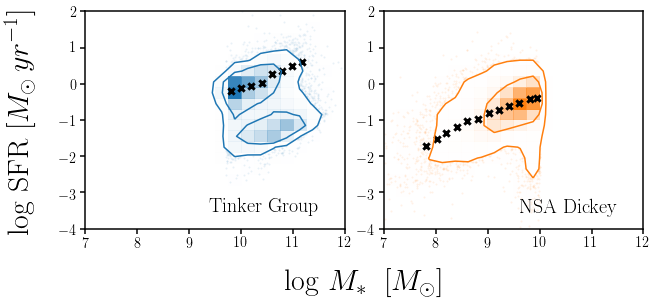

In [10]:
fig = plt.figure(1, figsize=(10,4))
bkgd = fig.add_subplot(111, frameon=False)

for i_data in range(len(logSFRs)):
    sub = fig.add_subplot(1,2, i_data+1)
    DFM.hist2d(logMstars[i_data], logSFRs[i_data], color='C'+str(i_data), 
               levels=[0.68, 0.95], range=[[7., 12.], [-4., 2.]], 
               plot_datapoints=True, fill_contours=False, plot_density=True, ax=sub) 
    sub.text(0.9, 0.1, catalog_labels[i_data], ha='right', va='center', transform=sub.transAxes, fontsize=20)

    fSFMS = fstarforms()
    fit_logm, fit_logsfr = fSFMS.fit(logMstars[i_data], logSFRs[i_data], method='gaussmix') 
    sub.scatter(fit_logm, fit_logsfr, c='k', marker='x', lw=3, s=40)

bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
bkgd.set_xlabel(r'log $M_* \;\;[M_\odot]$', labelpad=20, fontsize=30) 
bkgd.set_ylabel(r'log SFR $[M_\odot \, yr^{-1}]$', labelpad=20, fontsize=30) 
    
fig.subplots_adjust(wspace=0.15, hspace=0.15)
plt.show()

3 galaxies have nonsensical logM* or logSFR values
SFMS is not well defined in the M* bin11.3000110623-11.5000110623


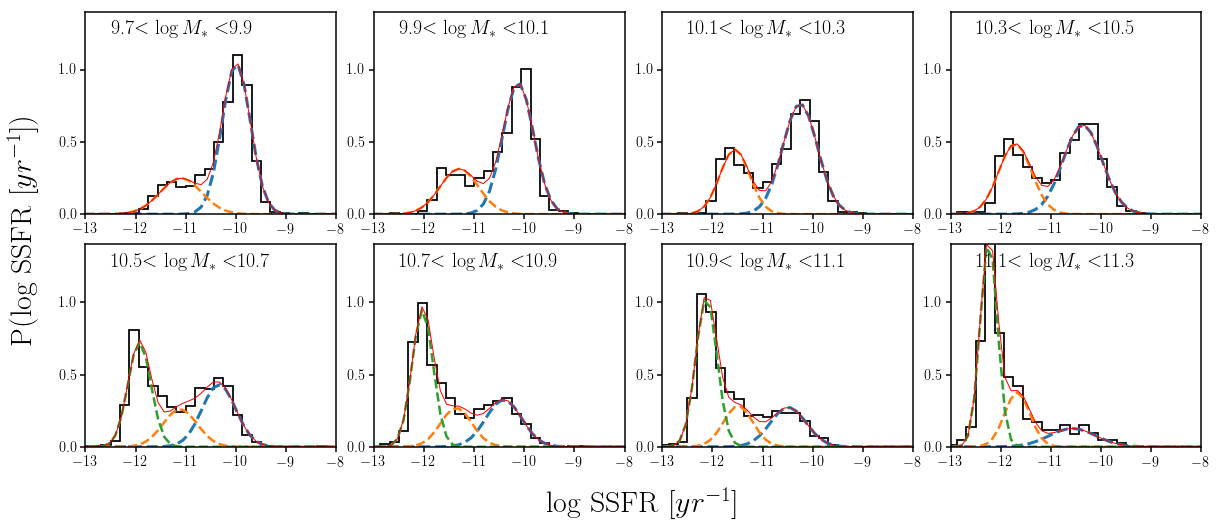

53 galaxies have nonsensical logM* or logSFR values


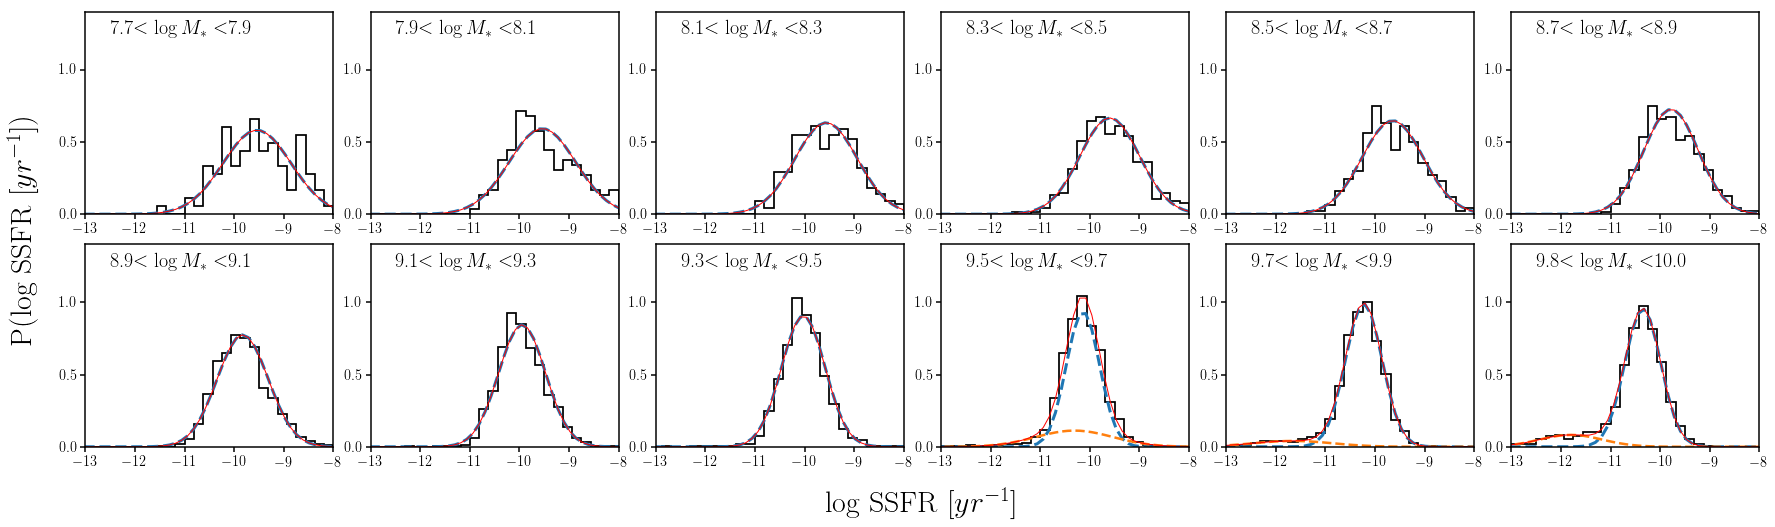

In [22]:
for i_data in range(len(logSFRs)):
    logm = logMstars[i_data]
    logsfr = logSFRs[i_data]
    fSFMS = fstarforms()
    fit_logm, fit_logsfr = fSFMS.fit(logm, logsfr, method='gaussmix') 
    
    n_col = int(np.ceil(float(len(fit_logm))/2))
    fig = plt.figure(figsize=(5*n_col, 8))
    bkgd = fig.add_subplot(111, frameon=False)
    for i_m in range(len(fit_logm)): 
        sub = fig.add_subplot(2, n_col, i_m+1)

        in_mbin = np.where((logm > fit_logm[i_m]-0.5*fSFMS._dlogm) & 
                (logm < fit_logm[i_m]+0.5*fSFMS._dlogm))
        sub.text(0.1, 0.9, 
                str(round(fit_logm[i_m]-0.5*fSFMS._dlogm,1))+'$<$ log$\,M_* <$'+str(round(fit_logm[i_m]+0.5*fSFMS._dlogm,1)), 
                ha='left', va='center', transform=sub.transAxes, fontsize=20)

        _ = sub.hist(logsfr[in_mbin] - logm[in_mbin], bins=32, 
                range=[-14., -8.], normed=True, histtype='step', color='k', linewidth=1.75)

        # plot the fits 
        xx = np.linspace(-14, -8, 50) 

        gmm_weights = fSFMS._gmix_weights[i_m]
        gmm_means = fSFMS._gmix_means[i_m]
        gmm_vars = fSFMS._gmix_covariances[i_m]


        for ii, icomp in enumerate(gmm_means.argsort()[::-1]): 
            if ii == 0: 
                sub.plot(xx, gmm_weights[icomp]*MNorm.pdf(xx, gmm_means[icomp], gmm_vars[icomp]), lw=3, ls='--')
                gmm_tot = gmm_weights[icomp]*MNorm.pdf(xx, gmm_means[icomp], gmm_vars[icomp])
            else: 
                sub.plot(xx, gmm_weights[icomp]*MNorm.pdf(xx, gmm_means[icomp], gmm_vars[icomp]), lw=2.5, ls='--')
                gmm_tot += gmm_weights[icomp]*MNorm.pdf(xx, gmm_means[icomp], gmm_vars[icomp])
        sub.plot(xx, gmm_tot, c='r', lw=1, ls='-')

        # x-axis
        sub.set_xlim([-13, -8])
        sub.set_xticks([-13, -12, -11, -10, -9, -8])
        sub.set_ylim([0., 1.4])
        sub.set_yticks([0., 0.5, 1.])
    bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    
    bkgd.set_ylabel(r'P(log SSFR  $[yr^{-1}])$', labelpad=20, fontsize=30) 
    bkgd.set_xlabel(r'log SSFR  $[yr^{-1}]$', labelpad=20, fontsize=30) 
    fig.subplots_adjust(hspace=0.15, wspace=0.15)
    plt.show()

3 galaxies have nonsensical logM* or logSFR values


fiducial log M* =10.5
logSFR_SFMS = 0.68 (logM* - 10.5) + 0.182


53 galaxies have nonsensical logM* or logSFR values


fiducial log M* =9.0
logSFR_SFMS = 0.616 (logM* - 9.0) + -0.879


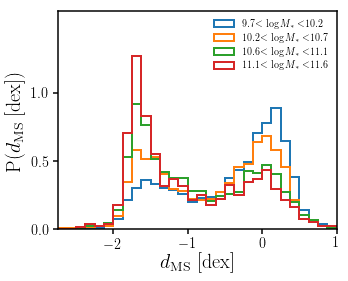

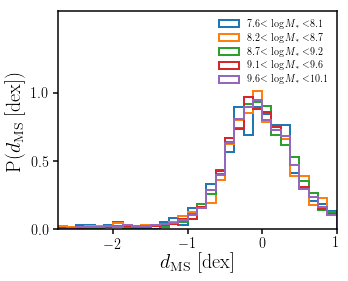

In [26]:
for i_data in range(len(logSFRs)):
    logm = logMstars[i_data]
    logsfr = logSFRs[i_data]
    
    # fit the SFMS and calculate dMS
    fSFMS = fstarforms()
    fit_logm, fit_logsfr = fSFMS.fit(logm, logsfr, method='gaussmix', dlogm=0.5) 
    F_sfms = fSFMS.powerlaw()
    dMS = fSFMS.d_MS(logm, logsfr) 
    
    # common sense cuts imposed in fSFMS
    logm = logm[fSFMS._sensecut]
    logsfr = logsfr[fSFMS._sensecut]
    
    fig = plt.figure(figsize=(5,4))
    sub = fig.add_subplot(111)
    for i_m in range(len(fit_logm)):  
        in_mbin = np.where((logm > fit_logm[i_m]-0.5*fSFMS._dlogm) & 
                (logm < fit_logm[i_m]+0.5*fSFMS._dlogm))
        mbin_lbl = str(round(fit_logm[i_m]-0.5*fSFMS._dlogm,1))+'$<$ log$\,M_* <$'+str(round(fit_logm[i_m]+0.5*fSFMS._dlogm,1)) 
        _ = sub.hist(dMS[in_mbin], bins=32, 
                range=[-3., 1.], normed=True, histtype='step', color='C'+str(i_m), 
                linewidth=2, label=mbin_lbl)
    # x-axis
    sub.set_xlim([-2.75, 1.])
    sub.set_xticks([-2, -1, 0, 1])
    sub.set_ylim([0., 1.6])
    sub.set_yticks([0., 0.5, 1.])
    sub.legend(loc='upper right') 

    sub.set_ylabel(r'P($d_\mathrm{MS}$  [dex])', fontsize=20) 
    sub.set_xlabel(r'$d_\mathrm{MS}$ [dex]', fontsize=20) 